<a href="https://colab.research.google.com/github/WilliamAshbee/AdvancedNetworkingGroupProject/blob/main/NetworkingProjectAnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os


In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [6]:
import seaborn as sns

In [7]:
sns.set(color_codes = True)

In [8]:
import matplotlib.pyplot as plt

In [9]:
%matplotlib inline

#what does this do

In [10]:
from numpy.random import seed

In [11]:
pip install tensorflow

In [12]:
#from tensorflow import set_random_seed https://stackoverflow.com/questions/58638701/importerror-cannot-import-name-set-random-seed-from-tensorflow-c-users-po

In [13]:
import tensorflow as tf

In [14]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [15]:
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector

In [16]:
from keras.models import Model

In [17]:
from keras import regularizers

In [18]:
seed(10)
tf.random.set_seed(10)#modified for v2, haven't verified it works deterministically 

In [19]:
testfile = "test.txt"
trainfile = "training.txt"
#datapath = '/content/drive/MyDrive/GeorgiaStateUniversity/trello/networkingproject/Bearing_Sensor_Data_pt1'
datapath = '/content/drive/MyDrive/GeorgiaStateUniversity/trello/networkingproject/BSD_1_2'

In [20]:
data_dir = datapath
merged_data = pd.DataFrame()
for filename in os.listdir(data_dir):
  try:
    value = os.path.join(data_dir, filename)
    #print(value)
    dataset = pd.read_csv(value, sep='\t')
    #print(dataset)
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
  except:
    continue

merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']


In [21]:
merged_data.index = pd.to_datetime(merged_data.index, format = '%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print('Dataset shape:', merged_data.shape)
merged_data.head()

Dataset shape: (982, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [22]:
merged_data.shape

(982, 4)

In [23]:
train = merged_data['2004-02-11':'2004-02-15 12:00:00']
test = merged_data['2004-02-15 12:00:00':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:",test.shape)


Training dataset shape: (439, 4)
Test dataset shape: (543, 4)


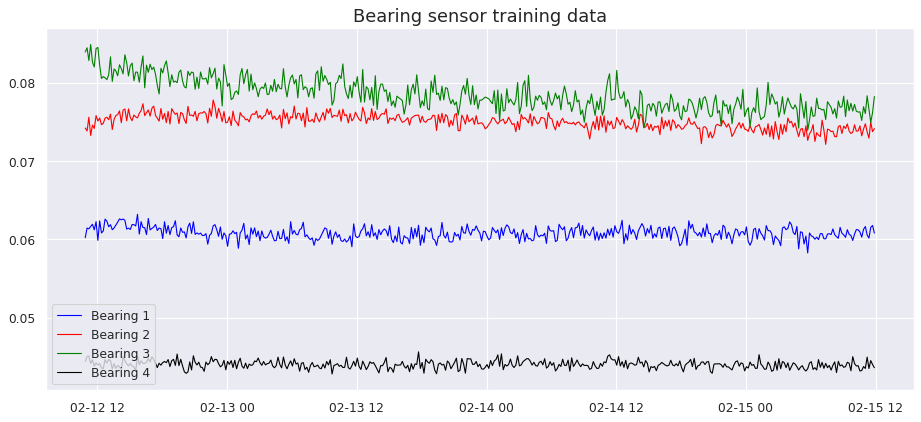

In [24]:
fig, ax = plt.subplots(figsize=(14,6),dpi=80)
ax.plot(train['Bearing 1'],label = 'Bearing 1', color='blue', animated=True, linewidth=1)
ax.plot(train['Bearing 2'],label = 'Bearing 2', color='red', animated=True, linewidth=1)
ax.plot(train['Bearing 3'],label = 'Bearing 3', color='green', animated=True, linewidth=1)
ax.plot(train['Bearing 4'],label = 'Bearing 4', color='black', animated=True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing sensor training data',fontsize=16)
plt.show()



In [25]:
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

In [26]:
train['Bearing 4'].shape


(439,)

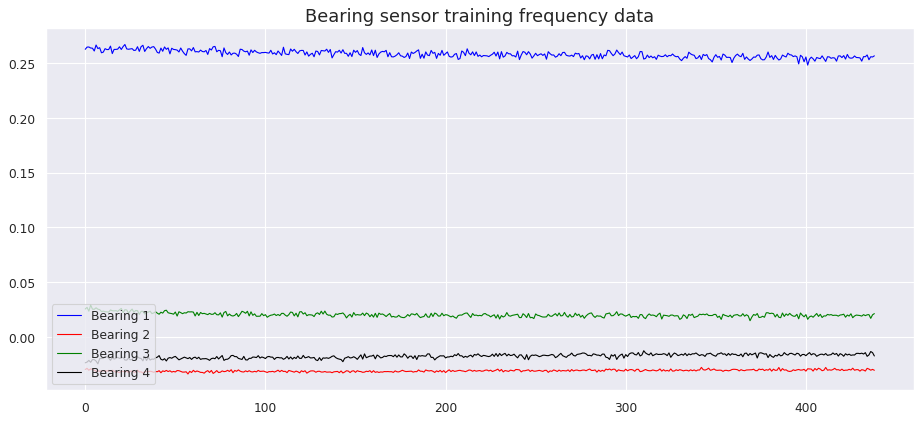

In [27]:
fig, ax = plt.subplots(figsize=(14,6),dpi=80)
ax.plot(train_fft[:,0].real,label='Bearing 1', color = 'blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag,label='Bearing 2', color = 'red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real,label='Bearing 3', color = 'green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real,label='Bearing 4', color = 'black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing sensor training frequency data', fontsize=16)
plt.show()

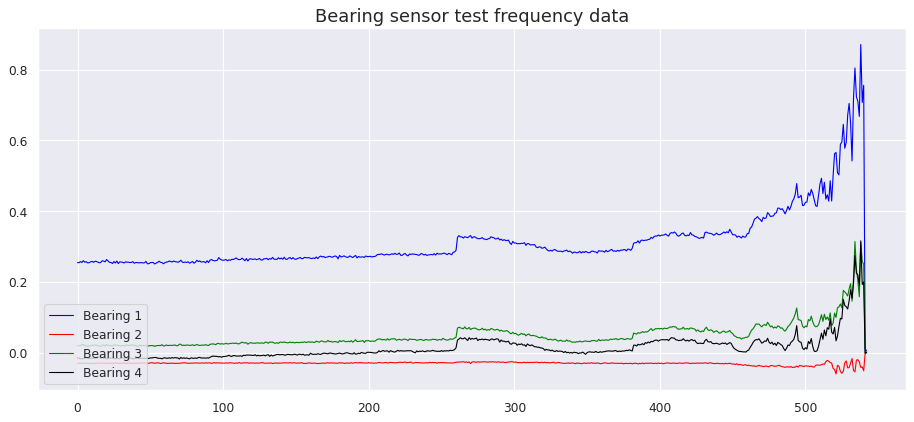

In [29]:
fig, ax = plt.subplots(figsize=(14,6),dpi=80)
ax.plot(test_fft[:,0].real,label='Bearing 1', color = 'blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag,label='Bearing 2', color = 'red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real,label='Bearing 3', color = 'green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real,label='Bearing 4', color = 'black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing sensor test frequency data', fontsize=16)
plt.show()

In [30]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = 'scaler_data'
joblib.dump(scaler, scaler_filename)


['scaler_data']

In [31]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print('Training data shape: ', X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print('Test data shape: ', X_test.shape)


Training data shape:  (439, 1, 4)
Test data shape:  (543, 1, 4)


In [35]:
#define the autoencoder network model
def autoencoder_model(X):
  inputs = Input(shape = (X.shape[1], X.shape[2]))
  L1 = LSTM(16, activation = 'relu', return_sequences=True,
            kernel_regularizer = regularizers.l2(0.00))(inputs)
  L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
  L3 = RepeatVector(X.shape[1])(L2)
  L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
  L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
  output = TimeDistributed(Dense(X.shape[2]))(L5)
  model = Model(inputs=inputs, outputs=output)
  return model


In [36]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 4)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 4)             

In [37]:
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split = 0.05).history


Epoch 1/100
42/42 [==============================] - 1s 18ms/step - loss: 0.4479 - val_loss: 0.3187
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3908 - val_loss: 0.2554
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 0.3106 - val_loss: 0.1761
Epoch 4/100
42/42 [==============================] - 0s 5ms/step - loss: 0.1677 - val_loss: 0.1376
Epoch 5/100
42/42 [==============================] - 0s 5ms/step - loss: 0.1085 - val_loss: 0.1196
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 0.1017 - val_loss: 0.1137
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 0.1009 - val_loss: 0.1075
Epoch 8/100
42/42 [==============================] - 0s 4ms/step - loss: 0.1007 - val_loss: 0.1092
Epoch 9/100
42/42 [==============================] - 0s 4ms/step - loss: 0.1002 - val_loss: 0.1096
Epoch 10/100
42/42 [==============================] - 0s 5ms/step - loss: 0.1001 - val_loss: 0.1061
Epoch 11

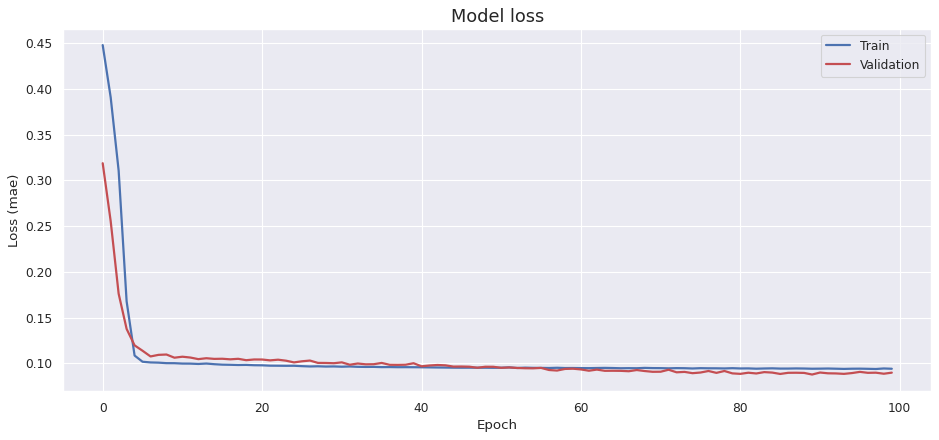

In [38]:
fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'], 'b', label='Train',linewidth=2)
ax.plot(history['val_loss'],'r',label='Validation',linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

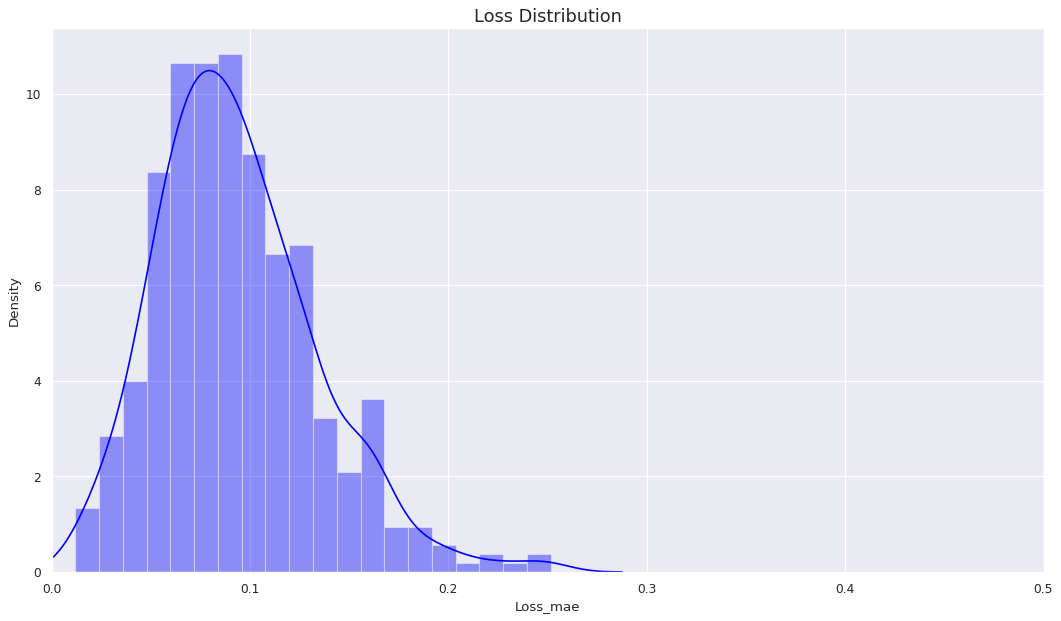

In [39]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae']= np.mean(np.abs(X_pred-Xtrain),axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'],bins = 20, kde = True, color = 'blue')
plt.xlim([0.0,.5])
